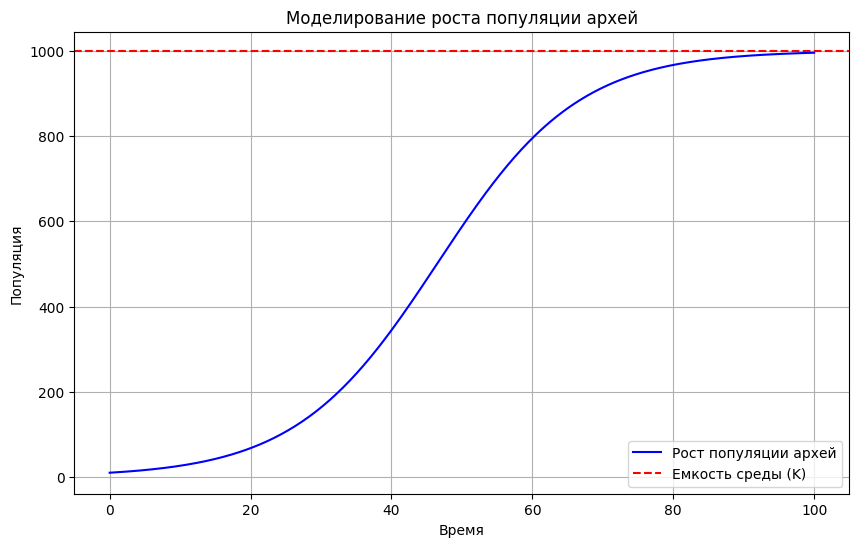

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры модели
r = 0.1  # коэффициент роста
K = 1000  # емкость среды
P0 = 10  # начальная популяция
t_max = 100  # максимальное время
dt = 0.25  # шаг по времени
num_steps = int(t_max / dt)  # количество шагов

# Инициализация массивов
t = np.linspace(0, t_max, num_steps)
P = np.zeros(num_steps)
P[0] = P0  # начальная популяция

# Метод Эйлера для решения дифференциального уравнения
for i in range(1, num_steps):
    dP = r * P[i-1] * (1 - P[i-1] / K)  # изменение популяции
    P[i] = P[i-1] + dP * dt  # обновление популяции

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(t, P, label='Рост популяции архей', color='blue')
plt.title('Моделирование роста популяции архей')
plt.xlabel('Время')
plt.ylabel('Популяция')
plt.axhline(y=K, color='r', linestyle='--', label='Емкость среды (K)')
plt.legend()
plt.grid()
plt.show()

ValueError: operands could not be broadcast together with shapes (48,98) (47,97) 

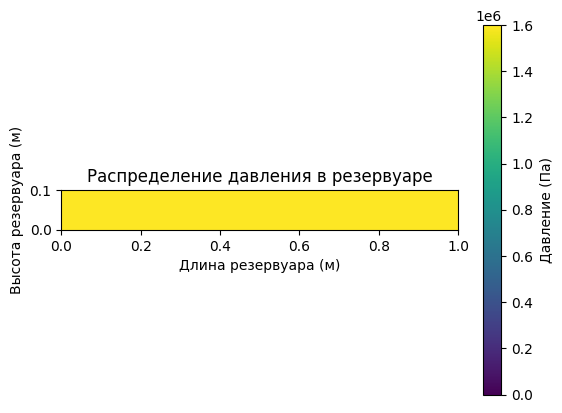

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy import ndimage

# Параметры жидкости
rho_oil = 800  # Плотность нефти (кг/м^3)
rho_methane = 0.717  # Плотность метана (кг/м^3)
mu_oil = 0.1   # Вязкость нефти (Па·с)
mu_methane = 0.01  # Вязкость метана (Па·с)
P_in = 16e5  # Давление на входе (Па)
L = 1.0    # Длина резервуара (м)
H = 0.1    # Высота резервуара (м)
nx, ny = 100, 50  # Размеры сетки
dx = L / nx
dy = H / ny
dt = 0.001  # Шаг по времени (с)

# Инициализация полей скорости и давления
u = np.zeros((ny, nx))  # Поле скорости по x
v = np.zeros((ny, nx))  # Поле скорости по y
p = np.ones((ny, nx)) * P_in  # Поле давления

# Настройка графика
fig, ax = plt.subplots()
cax = ax.imshow(p.T, origin='lower', extent=[0, L, 0, H], vmin=0, vmax=P_in)
plt.colorbar(cax, label='Давление (Па)')
plt.title('Распределение давления в резервуаре')
plt.xlabel('Длина резервуара (м)')
plt.ylabel('Высота резервуара (м)')

# Функция обновления для анимации
def update(frame):
    global u, v, p
    
    un = u.copy()
    vn = v.copy()
    
    # Уравнение движения для нефти и метана
    u[1:-1, 1:-1] = (un[1:-1, 1:-1] - 
                     un[1:-1, 1:-1] * dt/dx * (un[1:-1, 2:] - un[1:-1, :-2]) - 
                     vn[1:-1, 1:-1] * dt/dy * (un[2:, 1:-1] - un[:-2, 1:-1]) -
                     dt/(2*rho_oil*dx) * (p[1:-1, 2:] - p[1:-1, :-2]) +
                     mu_oil * (dt/dx**2 * (un[1:-1, 2:] - 2*un[1:-1, 1:-1] + un[1:-1, :-2]) +
                               dt/dy**2 * (un[2:, 1:-1] - 2*un[1:-1, 1:-1] + un[:-2, 1:-1]))

    v[1:-1, 1:-1] = (vn[1:-1, 1:-1] - 
                     un[1:-1, 1:-1] * dt/dx * (vn[1:-1, 2:] - vn[1:-1, :-2]) - 
                     vn[1:-1, 1:-1] * dt/dy * (vn[2:, 1:-1] - vn[:-2, 1:-1]) -
                     dt/(2*rho_methane*dy) * (p[2:, 1:-1] - p[:-2, 1:-1]) +
                     mu_methane * (dt/dx**2 * (vn[1:-1, 2:] - 2*vn[1:-1, 1:-1] + vn[0:ny-3,:-3]) +
                                   dt/dy**2 * (vn[2:, :-2] - vn[:-3,:-3]))

    # Обновление давления с использованием уравнения Пуассона
    b = rho_oil * ((u[2:, :-2] - u[:-2, :-2]) / (2*dx) +
                    (v[:-2, :-2] - v[:-2, :-3]) / (2*dy)) / dt

    p[0,:] += b[:,0]
    p[-3,:] += b[:,0]
    p[:,0] += b[:,0]
    p[:,-3:] += b[:,-3:]

    # Применение фильтра для сглаживания давления
    p = ndimage.gaussian_filter(p, sigma=0.5)

    # Обновление графика
    cax.set_array(p.T)
    return cax,

# Анимация
ani = FuncAnimation(fig, update, frames=1000, blit=True)

plt.show()